# Circunomics Assessment - Liam Mathers

## Task One

* Import the .csv file from the folder. This file consists of initial characterization batterie( Tests performed from 100% to 0%). what is the capacity of the batterie?
* Analyse the data in detail and extract the parameters of li ion cell equivalant circuit model(ECM). (Assume a 2nd order equivalant circuit model). Hint: try to use current interruption technique to extract the parameters.
* Extract ocv values of the cell w.r.t SoC and plot the curve.
* Find the other cell parameters and plot them w.r.t the SoC. hint: You can use any non linear optimization methods to parametrize the ECM model. i.e. scipy library, curve_fit etc.
* Plot w.r.t time V_actual(mesurement from the csv file) & V_simulated (voltage response to the current from the csv file) after building the model with the extracted parameters.
* Plot error with respect to time
* Plot the error distribution.



### Task 1-a 

- Import the .csv file from the folder. This file consists of initial characterization batterie( Tests performed from 100% to 0%). what is the capacity of the batterie?

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

file_path = 'C:/Users/liamk/OneDrive/Desktop/Circunomics/hiring_Battery_Eng_Challenge/CIR #001 Initial characterization.csv'

# excel formatting was visually inspected to determine best uploading/formatting methods
data = pd.read_csv(file_path, sep=';', decimal=',')

# read in DateTime format
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d:%m:%Y %H:%M:%S:%f')

data.head()

,DateTime,Voltage,Current,Capacity_step,State_of_Charge,Temperature,Checkup_No,Index,Charge_Throughput,Energy_Throughput
0,2022-04-06 09:38:31.382,4.186,0.0,0,100.25,25.8,0,Pause,113.8,425.1
1,2022-04-06 09:38:32.382,4.186,0.0,0,100.25,25.8,0,Pause,113.8,425.1
2,2022-04-06 09:38:33.382,4.186,0.0,0,100.25,25.8,0,Pause,113.8,425.1
3,2022-04-06 09:38:34.382,4.186,0.0,0,100.25,25.8,0,Pause,113.8,425.1
4,2022-04-06 09:38:35.382,4.186,0.0,0,100.25,25.8,0,Pause,113.8,425.1


In [10]:
# Calculate time difference in hours
data['Time_diff'] = data['DateTime'].diff().dt.total_seconds() / 3600

# Calculate amount of discharge capacity in each step
data['instant_dch'] = data['Current'] * data['Time_diff']

# Sum all discharge [Ah]
total_discharge = abs(data['instant_dch'].sum())

print(f'Battery Capacity is: {round(total_discharge,2)} Ah')


Battery Capacity is: 56.81 Ah


### Task 1-b

- Analyse the data in detail and extract the parameters of li ion cell equivalant circuit model(ECM). (Assume a 2nd order equivalant circuit model). Hint: try to use current interruption technique to extract the parameters.
    - Extract ocv values of the cell w.r.t SoC and plot the curve.
    - Find the other cell parameters and plot them w.r.t the SoC. hint: You can use any non linear optimization methods to parametrize the ECM model. i.e. scipy library, curve_fit etc.

In [11]:
# Create a new column to identify each discharge-pause group
data['Group'] = (data['Index'].shift() != data['Index']).cumsum()

# Group data by the 'Group' column
grouped_data = data.groupby('Group')

# Initialize dataframes
pause_data = pd.DataFrame()
discharge_data = pd.DataFrame()

for name, group in grouped_data:
    # If the test phase of the first row in the group is 'Pause'
    if group['Index'].iloc[0] == 'Pause':
        # concatenate the group data to the pause_data DataFrame
        pause_data = pd.concat([pause_data, group], axis=0)
    else :
        # concatenate the group data to the discharge_data DataFrame
        discharge_data = pd.concat([discharge_data, group], axis=0)

# Reset the index of the DataFrames
pause_data.reset_index(drop=True, inplace=True)
discharge_data.reset_index(drop=True, inplace=True)

# drop the first row for NaN
pause_data = pause_data.drop(pause_data.index[0])
discharge_data = discharge_data.drop(discharge_data.index[0])

def get_grouped_indices(data):
    # Create a function that finds the first and last index of every group
    def first_and_last_index(group):
        return group.index[0], group.index[-1]

    # Group by 'Group' and get the first and last index for each group
    grouped_indices = data.groupby('Group').apply(first_and_last_index)
    
    # Convert into a DataFrame
    grouped_indices = grouped_indices.apply(pd.Series)
    
    # Rename the columns
    grouped_indices.columns = ['FirstIndex', 'LastIndex']
    
    # Reset the index 
    grouped_indices.reset_index(inplace=True)
    
    return grouped_indices

# Filter the groups and apply the function
odd_groups = data[data['Group'] % 2 == 1]
even_groups = data[data['Group'] % 2 == 0]
grouped_odd = get_grouped_indices(odd_groups)
grouped_even = get_grouped_indices(even_groups)

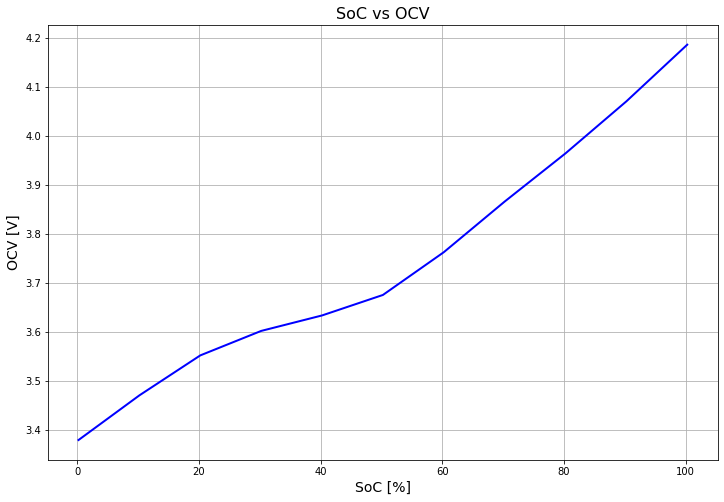

In [12]:
#assume constant SOC during pause and average voltage
ocv = pause_data.groupby('State_of_Charge')['Voltage'].mean()

plt.figure(figsize=[12,8])
plt.grid(True)
plt.plot(ocv.index, ocv.values, linewidth=2, color='blue')
plt.xlabel('SoC [%]', fontsize=14)
plt.ylabel('OCV [V]', fontsize=14)
plt.title('SoC vs OCV', fontsize=16)
plt.show()


In [13]:
# interpolating SOC-OCV values and adding it to main DF


ocv_soc = pd.DataFrame({'SOC': ocv.index,'OCV': ocv.values})

# Merge the main data with the soc_ocv_data
data = data.merge(ocv_soc, how='left', left_on='State_of_Charge', right_on='SOC')

# Interpolate the missing OCV values
data['OCV'] = data['OCV'].interpolate()

# Drop the first row
data.drop(data.index[0], inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)

#There are some NaN values in SOC
data['SOC'] = data['SOC'].interpolate()

#### Deriving parameters for every SOC

In [14]:
# Define a function representing the equivalent circuit model
def ecm_model(t, R0, R1, C1, R2, C2):
    V1 = R1 * (1 - np.exp(-t / (R1*C1)))
    V2 = R2 * (1 - np.exp(-t / (R2*C2)))
    return R0 + V1 + V2

# Optimimizing parameters using current interruption
def curve_fitting(data, func, groups):
    
    params = {} #initialize dictionary
    row_count = len(groups) #define length of unique groups
    coeff = np.zeros((row_count, 5))
    for i in range(row_count):
        
        # Get the first and last index of each pause/dch group to define value ranges
        start = groups.FirstIndex[i] 
        end = groups.LastIndex[i]
        time_range = data.DateTime[start:end]
        volt_range = data.Voltage[start:end]
        time_cum = time_range - time_range.iloc[0]
        time_sec = time_cum.dt.total_seconds()
        
        initial_guess = [0.01, 0.01, 1000, 0.01, 1000]# initial guesses for R0, R1, C1, R2, C2
        lower_bounds = [0, 0, 0, 0, 0]  # Lower bounds for R0, R1, C1, R2, C2
        upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]  # Upper bounds for R0, R1, C1, R2, C2
        optimal_parameters, covariance = curve_fit(ecm_model, time_sec, volt_range, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
        params[i] = optimal_parameters
        
    return params
    
# Estimate reduction in SOC from every dch phase
def cap_loss (data, groups): 
   
    row_count = len(groups)
    dch = []
    
    for i in range(row_count):
         # Get the first and last index of each pause/dch group to define value ranges
        start = groups.FirstIndex[i]
        end = groups.LastIndex[i]
        time_intervals = data.DateTime[start:end].diff().dt.total_seconds()/ 3600 #time between measurements in hr
        current = data.Current[start:end]
        charge_passed = current * time_intervals #discharge per measurement
        total_charge_passed = charge_passed.sum() #total discharge
       
        SOC_loss = (total_charge_passed / 56.81)*100 #proportional loss in SOC from each discharge phase
        dch.append(SOC_loss) # create series for each phase
    return dch

# find the correct parameters(R0, R1, C1, R2, C2) for the current respective SOC
def findparam (data, z, parameters):# data = ocv_soc list
    ocv = data['OCV'].iloc[::-1]   # Reverse series
    id = abs(ocv - z).argmin() #find closest ocv value to current voltage
    return parameters[10-id] #return correlating parameters

#finding soc from ocv
def findsoc (data, z):# data = main DF
    ocv = data['OCV']
    soc = data['SOC']
    id = abs(ocv - z).argmin() #find closest ocv value to current voltage
    return soc[id] #return correlating SOC

#finding ocv from soc
def findocv (data, z): # data = main DF
    ocv = data['OCV']
    soc = data['SOC']
    id = abs(soc - z).argmin() #find closest soc value to current voltage
    return ocv[id] #return correlating ocv

#Simulate Voltage response
def vsim (data, parameters, DCH_val):

    voltage = []
    vtemp = data['Voltage'].iloc[0] # define initial voltage
    
    total_time = np.array([])  # Array to store total time
    current_time = 0  # Variable to store current total time
    
    # Get the unique groups
    unique_groups = data['Group'].unique()

    # Loop for each unique group
    for group in unique_groups:
        if group == 1:  # Skip group 1 - too small (<10 values)
            continue
        df = data[data['Group'] == group]
        
        time = (df['Time_diff']*3600).cumsum().values
        total_time_group = time + current_time  # Add the current total time to the time array for total time
        current_time = total_time_group[-1]  # Update the current total time
        total_time = np.concatenate((total_time, total_time_group))  # Add the time array to the total time array
        
        if group % 2 == 0:  # Check if the group number is even - dch
            
            soc = findsoc(data, vtemp) # get soc at the start of this dch phase
            n = int(group/2)
            soctemp = soc + DCH_val[n-1] #new SOC  after dch
            vend = findocv(data, soctemp) #voltage at end of dch  
            volt = np.interp(time,[time[0],time[-1]],[vtemp,vend]) # interpolate to get voltages through
            voltage = np.concatenate((voltage,volt)) # add voltage to overall array
            vtemp = vend # define the starting voltage of next phase

        else:  # The group number is odd - current = 0
            
            optimal_p = findparam(ocv_soc, vtemp, parameters) # extract the parameters associated with current SOC
            volt = ecm_model(time, *optimal_p) # simulate voltages for length of pause
            voltage = np.concatenate((voltage,volt)) # add voltage to overall array
            vtemp = volt[-1] # define the starting voltage of next phase
    
    return voltage, total_time  # Return the voltage and total time arrays


In [15]:
# Derive Parameters for every 10%  decrease in SOC
param = curve_fitting(data, ecm_model, grouped_odd)

# Estimate Reduction in SOC for every DCH phase
soc_loss = cap_loss(data, grouped_even)

# Simulate voltage and extract correlated time series
voltage_sim, total_time = vsim(data,param,soc_loss)

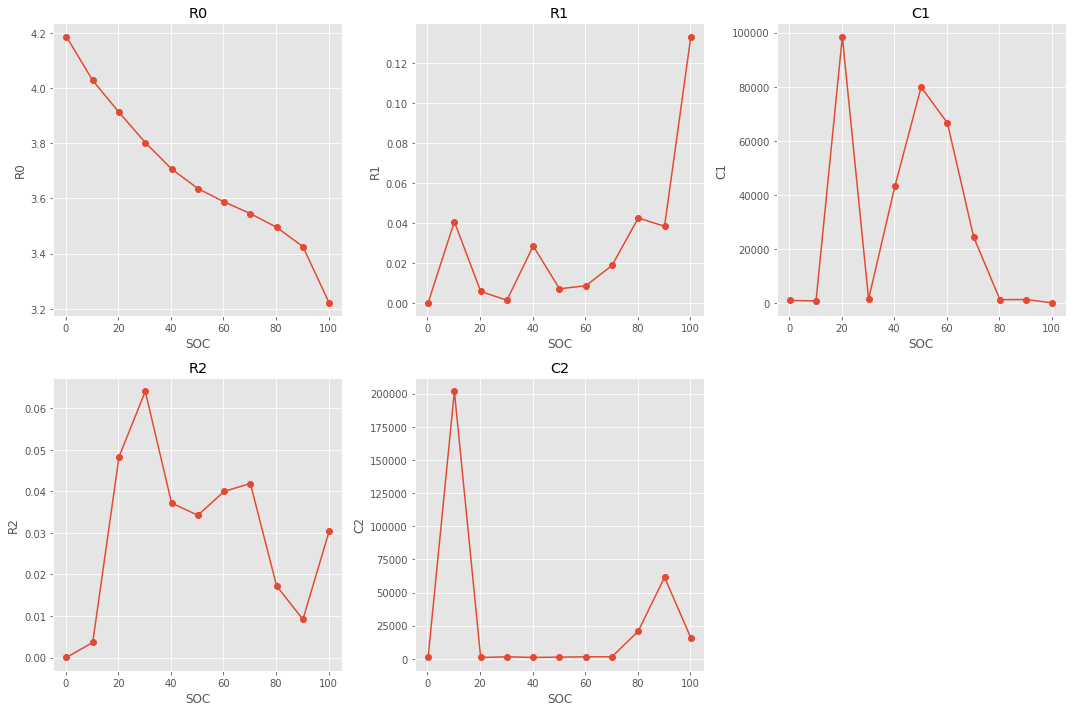

In [26]:
import matplotlib.pyplot as plt

# Extracting each parameter
R0 = [param[0] for param in param.values()]
R1 = [param[1] for param in param.values()]
C1 = [param[2] for param in param.values()]
R2 = [param[3] for param in param.values()]
C2 = [param[4] for param in param.values()]

SOC = ocv_soc['SOC'].values

# Plotting
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(SOC, R0, 'o-')
plt.title('R0')
plt.xlabel('SOC')
plt.ylabel('R0')

plt.subplot(2,3,2)
plt.plot(SOC, R1, 'o-')
plt.title('R1')
plt.xlabel('SOC')
plt.ylabel('R1')

plt.subplot(2,3,3)
plt.plot(SOC, C1, 'o-')
plt.title('C1')
plt.xlabel('SOC')
plt.ylabel('C1')

plt.subplot(2,3,4)
plt.plot(SOC, R2, 'o-')
plt.title('R2')
plt.xlabel('SOC')
plt.ylabel('R2')

plt.subplot(2,3,5)
plt.plot(SOC, C2, 'o-')
plt.title('C2')
plt.xlabel('SOC')
plt.ylabel('C2')

plt.tight_layout()
plt.show()


### Task 1-c
- Plot w.r.t time V_actual(mesurement from the csv file) & V_simulated (voltage response to the current from the csv file) after building the model with the extracted parameters.
    - Plot error with respect to time
    - Plot the error distribution.

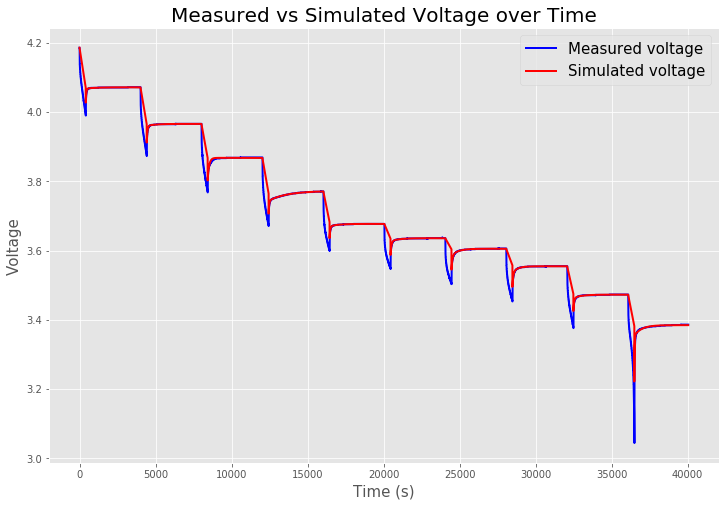

In [27]:
# Create a time difference column in the dataframe
data['Time_difference'] = (data['DateTime'] - start_time)

# Convert it into seconds
data['Time_difference'] = data['Time_difference'].dt.total_seconds()

plt.figure(figsize=[12,8])
plt.plot(data['Time_difference'], data['Voltage'], color='blue', linewidth=2, label='Measured voltage')
plt.plot(total_time, voltage_sim, color='red', linewidth=2, label='Simulated voltage')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Voltage', fontsize=15)
plt.title('Measured vs Simulated Voltage over Time', fontsize=20)
plt.legend(loc='upper right', fontsize=15)
plt.grid(True)
plt.show()



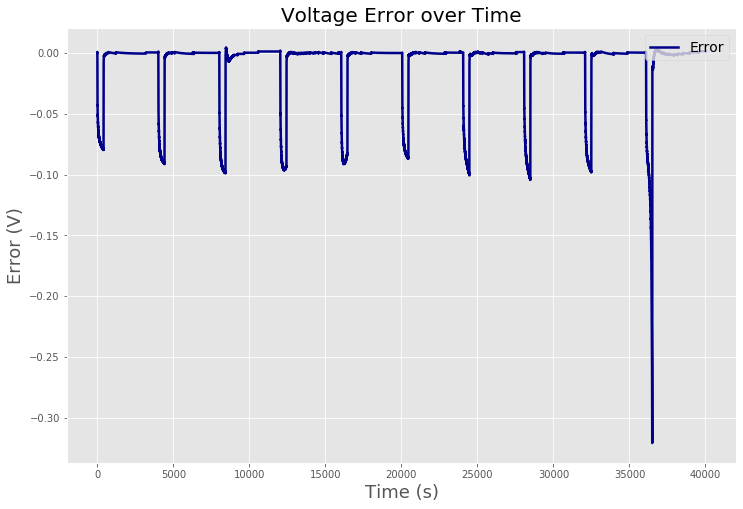

In [31]:
# Compute time in cumulative seconds for the data length that matches 'voltage_sim'
data['Time_difference'] = (data['DateTime'].iloc[:len(voltage_sim)] - start_time)
data['Time_difference'] = data['Time_difference'].dt.total_seconds()

# Calculate the error
error = data['Voltage'][:len(voltage_sim)] - voltage_sim


fig, ax = plt.subplots(figsize=[12,8])
ax.plot(data['Time_difference'][:len(voltage_sim)], error, color='darkblue', linewidth=2.5, label='Error')
ax.set_title('Voltage Error over Time', fontsize=20)
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Error (V)', fontsize=18)
ax.legend(loc='upper right', fontsize=14)


plt.show()

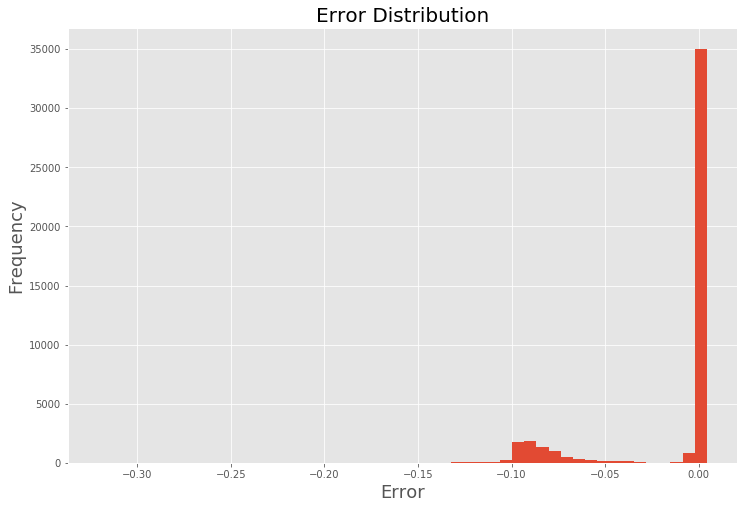

In [36]:
# error distribution
plt.figure(figsize=[12,8])
plt.hist(error, bins=50, label='Error distribution')
plt.title('Error Distribution', fontsize=20)
plt.xlabel('Error', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

## Task 2

- Import the .xls file from the folder describing the cycling aging charge data at different timeperiods over the life.
- Data preprocessing shall be done. Look for outliers, missing values if any. Add any additional attribtes for the sake of restructuring the data.
- Compute the SoC (build a function in python or matlab to compute the soc). Hint: take initial soc from the soc-ocv curve developed in the previous task.
- Calculate the SoH of the battery for every charge cycle and plot the Charge voltage w.r.t the Capacity. Hint: Overlap all charge curves in a single plot to see the ageing behaviour.

## Task 2-a
- Import the .xls file from the folder describing the cycling aging charge data at different timeperiods over the life.

In [32]:
file_path = 'C:/Users/liamk/OneDrive/Desktop/Circunomics/hiring_Battery_Eng_Challenge/cycles#001.xlsx'

data = pd.read_excel(file_path)
data.head()



,DateTime,Voltage,Current,Capacity
0,2022-04-07 09:34:22,3.517,0.0,0.0
1,2022-04-07 09:34:32,3.524,0.0,0.0
2,2022-04-07 09:34:42,3.530,0.0,0.0
3,2022-04-07 09:34:52,3.535,0.0,0.0
4,2022-04-07 09:35:02,3.538,0.0,0.0


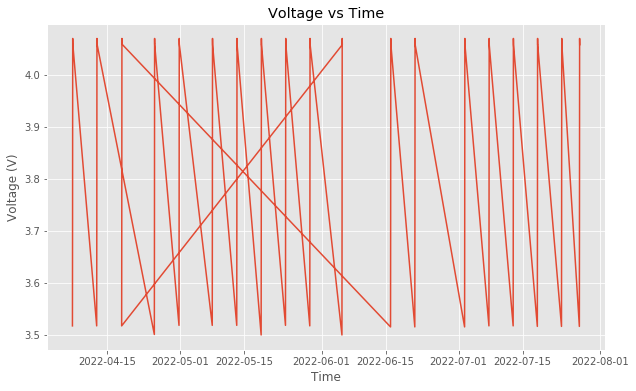

In [33]:

plt.figure(figsize=(10, 6))
plt.plot(data['DateTime'], data['Voltage'])
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time')
plt.grid(True)
plt.show()

## Task 2-b
- Data preprocessing shall be done. Look for outliers, missing values if any. Add any additional attribtes for the sake of restructuring the data.

Missing values in each column:
DateTime    0
Voltage     0
Current     0
Capacity    0
dtype: int64

Outliers in each numerical column:
Voltage     0
Current     0
Capacity    0
dtype: int64


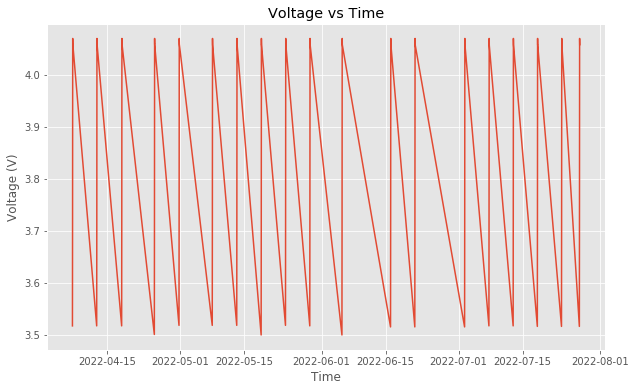

In [34]:
# Checking for missing values
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}\n")

# Checking for outliers using IQR method
# Select only numerical columns
numerical_columns = data.select_dtypes(include=[np.number])

Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Outliers are values lying beyond (Q3 + 1.5*IQR) and below (Q1 - 1.5*IQR)
outliers = ((numerical_columns < (Q1 - 1.5 * IQR)) | (numerical_columns > (Q3 + 1.5 * IQR))).sum()
print(f"Outliers in each numerical column:\n{outliers}")

# Check if the DateTime column is in ascending order
is_in_order = data['DateTime'].is_monotonic_increasing

if not is_in_order:
    data = data.sort_values('DateTime')

# Assuming 'data' is your pandas DataFrame and it has columns 'DateTime' and 'Voltage'
plt.figure(figsize=(10, 6))
plt.plot(data['DateTime'], data['Voltage'])
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time')
plt.grid(True)
plt.show()

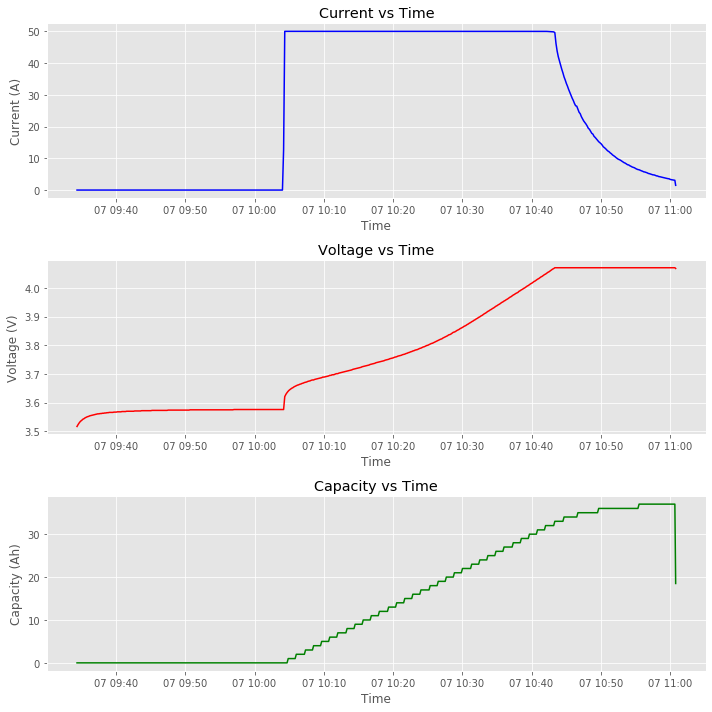

In [37]:
# Identify indices where current switches from positive to zero
switch_indices = np.where((data['Current'].shift(1) > 0) & (data['Current'] == 0))[0]


# only first cycle
data_first_cycle = data.iloc[:switch_indices[0]]

# Plotting the data for the first cycle
fig, axs = plt.subplots(3, figsize=(10, 10))

# Plot for Current vs Time
axs[0].plot(data_first_cycle['DateTime'], data_first_cycle['Current'], color='blue')
axs[0].set_title('Current vs Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Current (A)')

# Plot for Voltage vs Time
axs[1].plot(data_first_cycle['DateTime'], data_first_cycle['Voltage'], color='red')
axs[1].set_title('Voltage vs Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Voltage (V)')

# Plot for Capacity vs Time
axs[2].plot(data_first_cycle['DateTime'], data_first_cycle['Capacity'], color='green')
axs[2].set_title('Capacity vs Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Capacity (Ah)')

plt.tight_layout()
plt.show()


## Task 2-c
- Compute the SoC (build a function in python or matlab to compute the soc). Hint: take initial soc from the soc-ocv curve developed in the previous task.

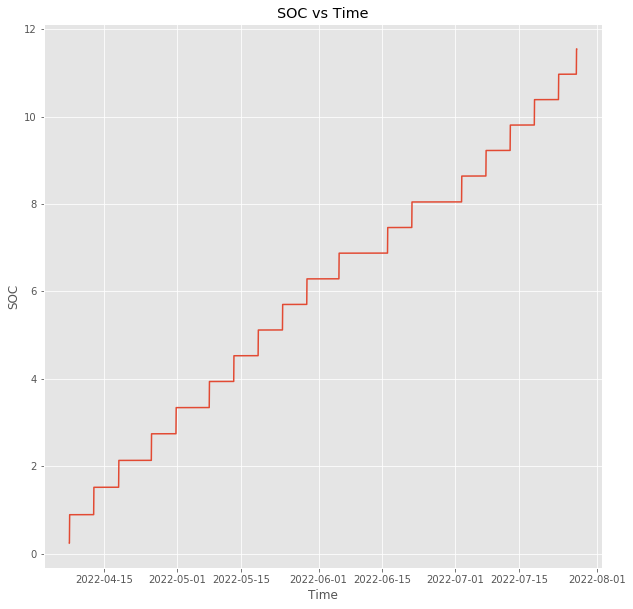

In [45]:
def calculate_soc(current, time, initial_soc, total_capacity):
    
    # Calculate the time intervals in hours
    time_intervals = np.diff(time) / 3600
    
    # Calculate the average current in each interval
    average_current = 0.5 * (current[:-1] + current[1:])

    # Calculate the charge in each interval
    charge_passed = average_current * time_intervals
    
    # Integrate the charge passed to find the total charge 
    total_charge_passed = np.cumsum(charge_passed)
    
    # Calculate the state of charge based on the total charge
    soc = initial_soc + total_charge_passed / total_capacity
    
    # Add the initial soc to the start of the soc array
    soc = np.concatenate(([initial_soc], soc))
    
    return soc

# Given OCV-SOC data
soc = ocv.index.values
ocv_values = ocv.values

# Your first voltage value
first_voltage = data['Voltage'].iloc[0]

# Interpolate to find the corresponding SOC
# Matched initial voltage to ocv-soc relationship
#initial_soc = np.interp(first_voltage, ocv_values, soc) 

initial_soc = .24 

total_capacity = 56.81 # total capacity of your battery

# Get the current and time data from the dataframe
current = data['Current'].to_numpy()
time = (data['DateTime'] - data['DateTime'].iloc[0]).dt.total_seconds().to_numpy()

# Calculate the state of charge
soc = calculate_soc(current, time, initial_soc, total_capacity)

# Add the soc to the dataframe
data['SoC'] = soc



# Assuming 'data' is your pandas DataFrame and it has columns 'DateTime' and 'Voltage'
plt.figure(figsize=(10, 10))
plt.plot(data['DateTime'], data['SoC'])
plt.xlabel('Time')
plt.ylabel('SOC')
plt.title('SOC vs Time')
plt.grid(True)
plt.show()

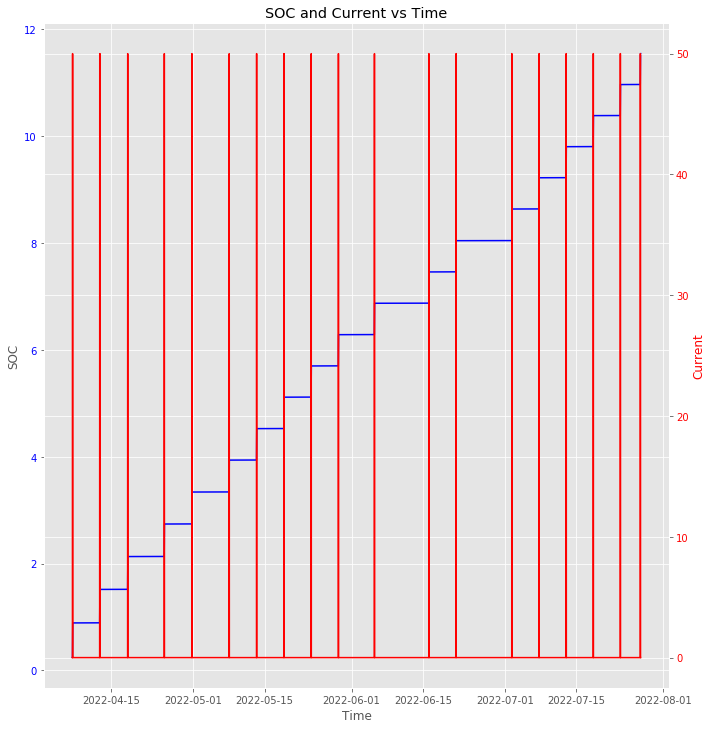

In [46]:
# Making sure that current pulses correlate with increase in SOC

fig, ax1 = plt.subplots(figsize=(10, 10))

# Plot SOC vs Time
ax1.plot(data['DateTime'], data['SoC'], color='blue', label='SOC')
ax1.set_xlabel('Time')
ax1.set_ylabel('SOC')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx() 


ax2.plot(data['DateTime'], data['Current'], color='red', label='Current')
ax2.set_ylabel('Current', color='red')  
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  
plt.title('SOC and Current vs Time')
plt.show()


## Task 2-d
    - Calculate the SoH of the battery for every charge cycle and plot the Charge voltage w.r.t the Capacity. 
    

In [43]:
# identify current switches
data['Cycle_Change'] = ((data['Current'] > 0) & (data['Current'].shift(1) == 0)) | ((data['Current'] == 0) & (data['Current'].shift(1) > 0))
data['Cycle_Number'] = data['Cycle_Change'].cumsum()

# extract data for each cycle into separate DataFrames:
cycles = [group for _, group in data.groupby('Cycle_Number')]

data.head()

,DateTime,Voltage,Current,Capacity,SoC,Cycle_Change,Cycle_Number
0,2022-04-07 09:34:22,3.517,0.0,0.0,15.921849,False,0
1,2022-04-07 09:34:32,3.524,0.0,0.0,15.921849,False,0
2,2022-04-07 09:34:42,3.530,0.0,0.0,15.921849,False,0
3,2022-04-07 09:34:52,3.535,0.0,0.0,15.921849,False,0
4,2022-04-07 09:35:02,3.538,0.0,0.0,15.921849,False,0


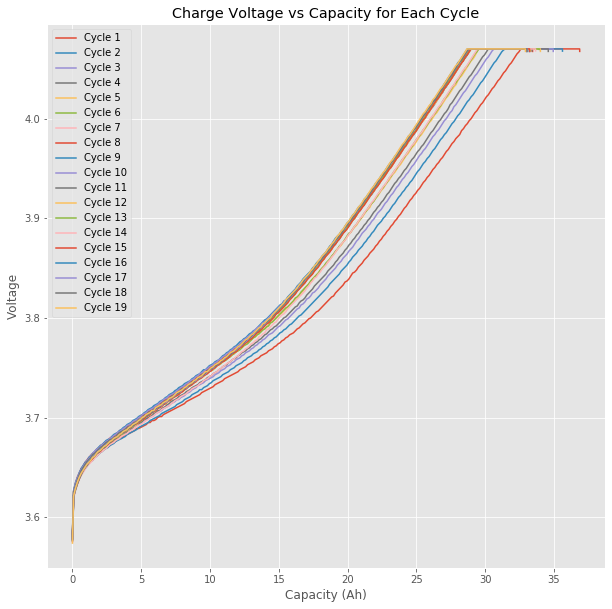

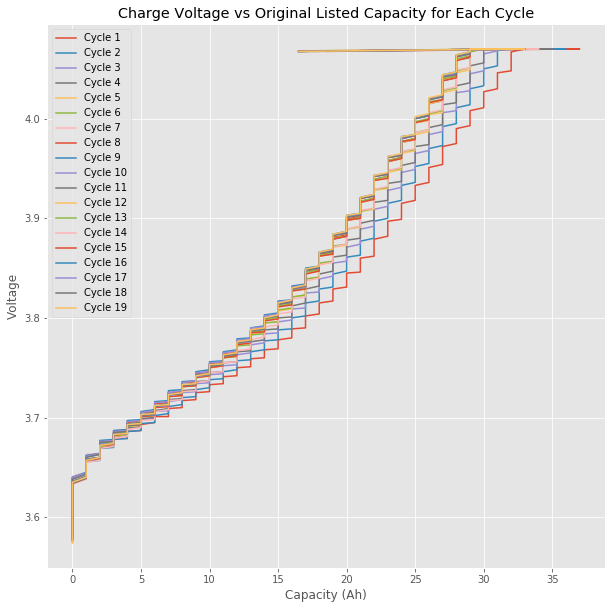

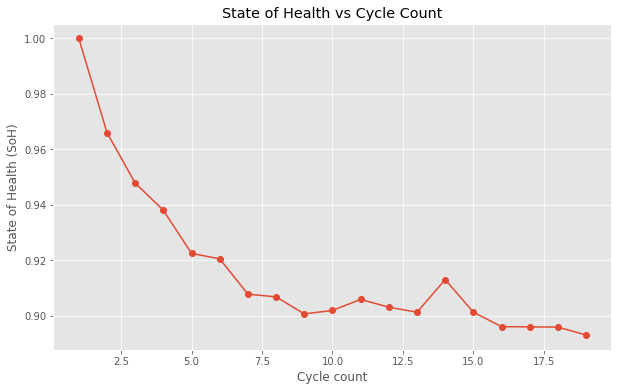

In [44]:
charge_per_cycle = []  # list to store charge for each cycle
soh_per_cycle = []  # list to store SoH for each cycle
Q0 = 56.81  # Nominal capacity
soh = []  # This list will store the SoH for each cycle

plt.figure(figsize=(10, 10))

# Get only cycles with non-zero charge
cycles_charge = [cycle for cycle in cycles if cycle['Current'].sum() != 0]

for i, cycle in enumerate(cycles_charge):
    # Convert time intervals in seconds
    timestamps = cycle['DateTime'].apply(lambda dt: dt.timestamp())
    time_intervals = np.diff(timestamps)  # in seconds
    
    # Calculate the average current in each interval
    average_current = 0.5 * (cycle['Current'].iloc[:-1].values + cycle['Current'].iloc[1:].values)
    
    # Calculate the charge in each interval
    charge_passed = average_current * time_intervals  # in Coulombs
    
    # Integrate  to find the total charge 
    total_charge_passed = np.cumsum(charge_passed)  # in Coulombs
    
    # Convert charge to Ampere-hours
    capacity_Ah = total_charge_passed / 3600  # in Ah
    
    # Prepend initial capacity
    capacity_Ah = np.concatenate(([0], capacity_Ah))
    
    # Add the calculated capacity to the cycle dataframe
    cycle['Calculated Capacity'] = capacity_Ah
    
    # Plot the charge voltage vs the manually calculated capacity for this cycle
    plt.plot(capacity_Ah, cycle['Voltage'], label=f'Cycle {i+1}')
    
    charge_per_cycle.append(capacity_Ah[-1])
    
     # Calculate the SoH for this cycle and add it to the list
    if len(charge_per_cycle) == 1:  # if this is the first cycle
        soh = 1  # SoH is 100%
    else:  # for subsequent cycles
        soh = capacity_Ah[-1] / charge_per_cycle[0]  # divide by the charge in the first cycle

    soh_per_cycle.append(soh)


plt.ylabel('Voltage')
plt.xlabel('Capacity (Ah)')
plt.title('Charge Voltage vs Capacity for Each Cycle')
plt.legend()  # Add a legend
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10))

for i, cycle in enumerate(cycles_charge):
    # Plot the charge voltage vs the original listed capacity for this cycle
    plt.plot(cycle['Capacity'], cycle['Voltage'], label=f'Cycle {i+1}')

plt.ylabel('Voltage')
plt.xlabel('Capacity (Ah)')
plt.title('Charge Voltage vs Original Listed Capacity for Each Cycle')
plt.legend()  # Add a legend
plt.grid(True)
plt.show()


# Now let's plot the SoH for each cycle
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(soh_per_cycle)+1), soh_per_cycle,'o-')
plt.xlabel('Cycle count')
plt.ylabel('State of Health (SoH)')
plt.title('State of Health vs Cycle Count')
plt.grid(True)
plt.show()
